#  아이디어 :텍스트가 삽입된 이미지에서 텍스트를 지워주는 모델

   # 1. 데이터 준비

In [11]:
import numpy as np 
import matplotlib.pyplot as plt

######pfcn.npz 데이터 로드###
data = np.load('pfcn.npz')
train_images = data['train_images'] 
test_images = data['test_images']

np.shape(test_images),np.shape(train_images)

((300, 100, 75, 3), (1700, 100, 75, 3))

In [12]:
##### y 데이터 구성##########
ydata = np.concatenate([train_images, test_images])

(2000, 100, 75, 3)

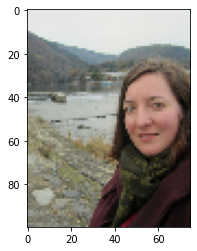

In [13]:
### y 데이터 사진 및 shape 확인####
plt.figure(figsize=(15,4))
plt.imshow(ydata[2])
np.shape(ydata) 

(<matplotlib.image.AxesImage at 0x1ec09d332c8>, dtype('uint8'))

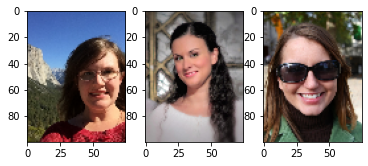

In [14]:
import cv2


ydata = cv2.normalize(ydata, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)

ydata = ydata.astype(np.uint8)
                     
# 제대로 변환됐는지 확인
plt.subplot(1,3,1)
plt.imshow(ydata[0]), ydata[0].dtype

plt.subplot(1,3,2)
plt.imshow(ydata[299]), ydata[299].dtype

plt.subplot(1,3,3)
plt.imshow(ydata[1999]), ydata[1999].dtype

# 1-2. x 데이터 제작 : 이미지에 텍스트 넣기

In [15]:
import cv2
import random
import copy

temp = copy.deepcopy(ydata)


total_data_length = len(ydata) # 이미지 개수
xdata =[] # 모자이크 이미지 저장할 배열
text = 'Bon Appetit!' # 이미지에 틀어갈 텍스트
# 색깔 지정
blue = (255, 0, 0)
green= (0, 255, 0)
red= (0, 0, 255)
color_list = [blue, green,red]


# 폰트 지정
font =  cv2.FONT_HERSHEY_DUPLEX


for index in range(0 ,total_data_length):
    #텍스트 생성될 위치 무작위로(대신 화면 안에선 보이게)
    x = random.randrange(0,30)
    y = random.randrange(0,85)
    
    color = random.choice(color_list)
    # 이미지 불러오기
    image = temp[index]
    
    
    
    # 이미지에 텍스트 추가
    image = cv2.putText(image,  # 텍스트 삽입될 이미지
                text, # 텍스트
                (x,y), # 좌표
                font,  #폰트 스타일
                0.3,  # 폰트 크기
                color, # 무작위로 지정된 컬러
                2, # 폰트 굵기
                ) 
    xdata.append(image)


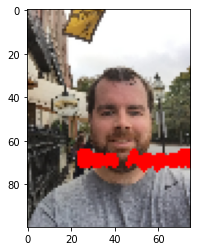

In [16]:
plt.imshow(xdata[1])

xdata 개수:2000
xdata 타입:<class 'list'>


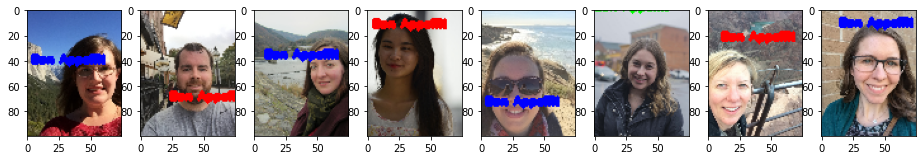

In [17]:
# xdata 개수 및 모자이크 이미지 확인
print('xdata 개수:'+ str(len(xdata))  + '\nxdata 타입:' + str((type(xdata))))

plt.figure(figsize=(20,10))
plt.subplot(1,10,1)
plt.imshow(xdata[0])

plt.subplot(1,10,2)
plt.imshow(xdata[1])

plt.subplot(1,10,3)
plt.imshow(xdata[2])

plt.subplot(1,10,4)
plt.imshow(xdata[3])

plt.subplot(1,10,5)
plt.imshow(xdata[4])

plt.subplot(1,10,6)
plt.imshow(xdata[5])

plt.subplot(1,10,7)
plt.imshow(xdata[6])

plt.subplot(1,10,8)
plt.imshow(xdata[7])

In [18]:
# xdata를 array로 바꾸어줍니다
xdata = np.array(xdata)
type(xdata)

numpy.ndarray

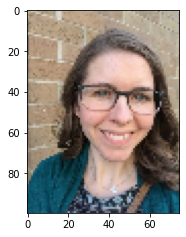

In [38]:
# ydata는 안전한지 확인
plt.subplot(1,2,1)
plt.imshow(ydata[7])

In [21]:
real_x = xdata/255
real_y = ydata/255
# 이미지가 0에서 255사이의 값이 나오도록해줍니다.

In [22]:
def shapecheck(*dataset):
    for data in dataset:
        print(np.shape(data))
shapecheck(real_x, real_y)

(2000, 100, 75, 3)
(2000, 100, 75, 3)


# 2. train/ test data 제작

In [24]:
from sklearn.model_selection import train_test_split
x_train,x_test, y_train, y_test= train_test_split(real_x, real_y,test_size=0.2, random_state=111)

In [25]:
def shapecheck(*dataset):
    for data in dataset:
        print(np.shape(data))
shapecheck(x_train, y_train, x_test, y_test)

(1600, 100, 75, 3)
(1600, 100, 75, 3)
(400, 100, 75, 3)
(400, 100, 75, 3)


# 3. 모델제작 

In [26]:
from keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Flatten, Reshape
from keras.models import Model
from keras.layers import BatchNormalization, Dropout, Activation, MaxPool2D, concatenate

def conv2d_block(x, channel):
    x = Conv2D(channel, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(channel, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def unet_like():
    inputs = Input((100, 75, 3))

    c1 = conv2d_block(inputs, 16)
    p1 = MaxPool2D((2,2))(c1)
    p1 = Dropout(0.1)(p1)

    c2 = conv2d_block(p1, 32)
    p2 = MaxPool2D((2,2))(c2)
    p2 = Dropout(0.1)(p2)

    c3 = conv2d_block(p2, 64)
    p3 = MaxPool2D((2,2))(c3)
    p3 = Dropout(0.1)(p3)

    c4 = conv2d_block(p3, 128)
    p4 = MaxPool2D((2,2))(c4)
    p4 = Dropout(0.1)(p4)

    c5 = conv2d_block(p4, 256)

    u6 = Conv2DTranspose(128, 2, 2, output_padding=(0,1))(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(0.1)(u6)
    c6 = conv2d_block(u6, 128)

    u7 = Conv2DTranspose(64, 2, 2, output_padding=(1,0))(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(0.1)(u7)
    c7 = conv2d_block(u7, 64)

    u8 = Conv2DTranspose(32, 2, 2, output_padding=(0,1))(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(0.1)(u8)
    c8 = conv2d_block(u8, 32)

    u9 = Conv2DTranspose(16, 2, 2, output_padding=(0,1))(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(0.1)(u9)
    c9 = conv2d_block(u9, 16)

    outputs = Conv2D(3, (1,1), activation="sigmoid")(c9)

    model = Model(inputs, outputs)
    return model





# 4. model summary

In [27]:
model_unet = unet_like()
model_unet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 75, 3)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 100, 75, 16)  448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 100, 75, 16)  64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 100, 75, 16)  0           batch_normalization[0][0]        
______________________________________________________________________________________________

# 5. model compile & run

In [28]:
model_unet.compile(loss="mse",optimizer="adam", metrics=["accuracy"])

In [29]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=20)

modelpath=".\\Ch14-4-bestmodel.hdf5"


checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=0, save_best_only=True)

In [30]:
hist = model_unet.fit(x_train, y_train, validation_data=(x_test, y_test), validation_steps=1, callbacks=[checkpointer], epochs=20)

Epoch 1/20
50/50 [==============================] - 46s 430ms/step - loss: 0.0298 - accuracy: 0.3162 - val_loss: 0.0574 - val_accuracy: 0.6458
Epoch 2/20
50/50 [==============================] - 10s 198ms/step - loss: 0.0105 - accuracy: 0.6097 - val_loss: 0.0511 - val_accuracy: 0.7046
Epoch 3/20
50/50 [==============================] - 10s 199ms/step - loss: 0.0076 - accuracy: 0.6822 - val_loss: 0.0489 - val_accuracy: 0.6961
Epoch 4/20
50/50 [==============================] - 10s 198ms/step - loss: 0.0059 - accuracy: 0.7197 - val_loss: 0.0358 - val_accuracy: 0.6941
Epoch 5/20
50/50 [==============================] - 10s 198ms/step - loss: 0.0051 - accuracy: 0.7389 - val_loss: 0.0241 - val_accuracy: 0.6790
Epoch 6/20
50/50 [==============================] - 10s 198ms/step - loss: 0.0044 - accuracy: 0.7517 - val_loss: 0.0152 - val_accuracy: 0.7327
Epoch 7/20
50/50 [==============================] - 10s 198ms/step - loss: 0.0043 - accuracy: 0.7643 - val_loss: 0.0094 - val_accuracy: 0.7447

# 6. result visualize

<Figure size 864x288 with 0 Axes>

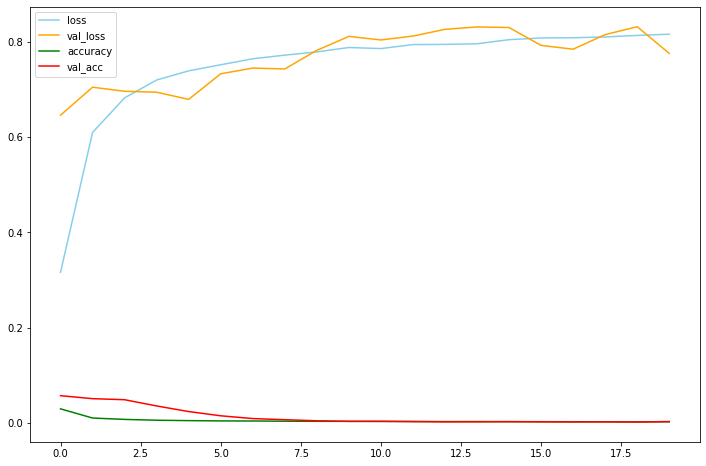

In [31]:
plt.figure(figsize=(12,4))

plt.figure(figsize=(12,8))
plt.plot(hist.history['accuracy'],c='skyblue')
plt.plot(hist.history['val_accuracy'],c='orange')
plt.plot(hist.history['loss'],c='green')
plt.plot(hist.history['val_loss'],c='red')
plt.legend(['loss','val_loss', 'accuracy','val_acc'])
plt.show()

# 7. model predict

Text(0.5, 1.0, 'model_result')

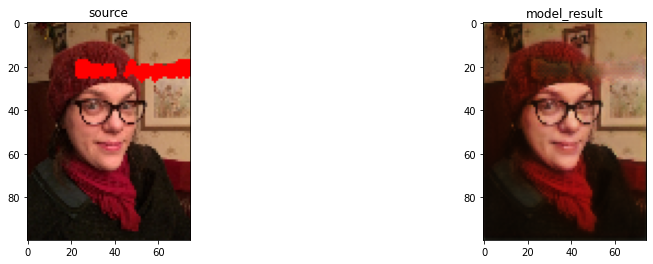

In [37]:
source = x_test[:10]
model_result = model_unet.predict(x_test[:10])

plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.imshow(source[8])
plt.title('source')

plt.subplot(1,2,2)
plt.imshow(model_result[8])
plt.title('model_result')